<a href="https://colab.research.google.com/github/tanvirtaher32/Sarcasm-Detection/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Unique tokens: 29753
Vocab size: 29754
Shape of X_train_pad: (38730, 25)
Shape of y_train: (38730,)
Shape of X_test_pad: (16598, 25)
Shape of y_test: (16598,)
Accuracy: 0.906615254849982
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      8991
           1       0.91      0.88      0.90      7607

    accuracy                           0.91     16598
   macro avg       0.91      0.90      0.91     16598
weighted avg       0.91      0.91      0.91     16598



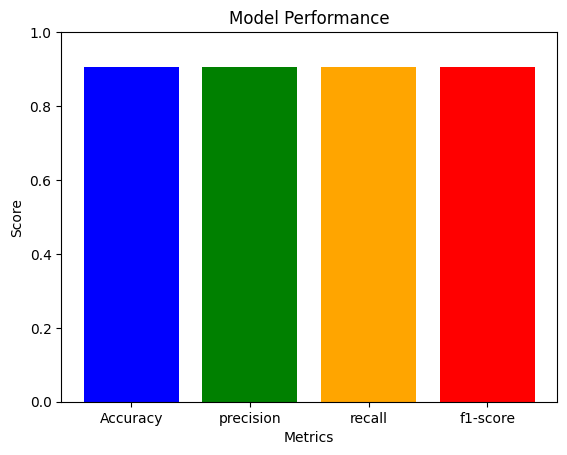

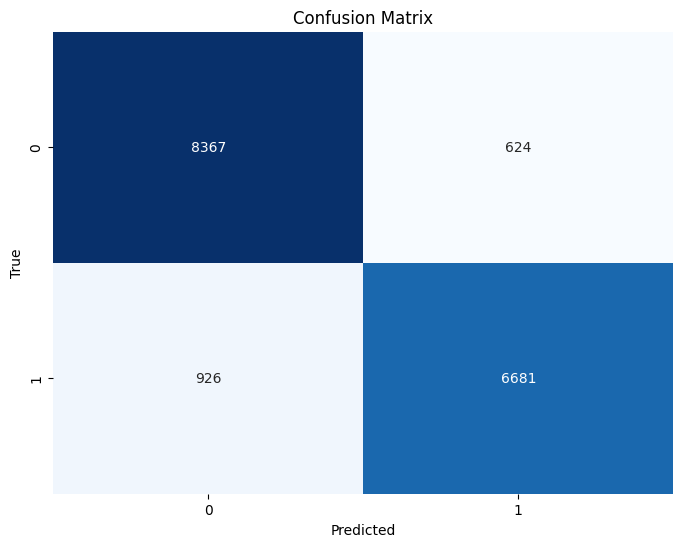

Confusion Matrix:
[[8367  624]
 [ 926 6681]]


In [ ]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Load the dataset
data_1 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/testdata/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data = pd.concat([data_1, data_2])

# Clean the text
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x: x[0] != '@', text.split()))

    ###########   for emoji subtraction
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

# Clean and tokenize the headlines
def clean_tokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        tokens = nltk.word_tokenize(line)
        head_lines.append(tokens)

    return head_lines

head_lines = clean_tokenize(data)

# Tokenize and pad sequences
validation_split = 0.3
max_length = 25

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("Unique tokens:", len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('Vocab size:', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment = data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_pad, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test_pad)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred)
classification_report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics values
metrics = ['precision', 'recall', 'f1-score']
values = [classification_report['weighted avg'][metric] for metric in metrics]

# Plotting the results
labels = ['Accuracy'] + metrics

fig, ax = plt.subplots()
ax.bar(labels, [accuracy] + values, color=['blue', 'green', 'orange', 'red'])
ax.set_ylim([0, 1])
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance')

plt.show()
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate the plots
plot_confusion_matrix(confusion_matrix)

print('Confusion Matrix:')
print(confusion_matrix)
